In [2]:
import os, sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
sc=spark.SparkContext()
sql=spark.SQLContext(sc)

In [3]:
os.chdir("/home/fvalle/phd/TWO-NN/")
from TwoNN import twonn_dimension

In [4]:
os.chdir("/home/fvalle/phd/master_thesis/gtex/")

In [5]:
genes = sql.read.option("header",'true').csv('/home/fvalle/phd/master_thesis/genes.txt')
genes.registerTempTable("genes")
genes.select("type_of_gene").distinct().show()
pc = sql.sql("SELECT * FROM genes WHERE type_of_gene='protein-coding'")
pc_list = list(pc.select('_c0').toPandas().values.T[0])

+--------------+
|  type_of_gene|
+--------------+
|          rRNA|
|         ncRNA|
|       unknown|
|         scRNA|
|      microRNA|
|         snRNA|
|     antisense|
|        snoRNA|
|        pseudo|
|protein-coding|
|    intergenic|
+--------------+



In [6]:
df = sql.read.option("header",True).option("delimiter",'\t').csv("/home/fvalle/phd/master_thesis/gtex/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_reads.gct")
df = df.withColumn('ensg',udf(lambda x: x[:15], StringType())(col('Name')))
df = df.filter(col("ensg").isin(pc_list))

In [7]:
df_files = pd.read_csv("/home/fvalle/phd/master_thesis/gtex/files.dat.ok", index_col=0)

In [8]:
tissues = df_files['primary_site'].unique()

In [11]:
model=PCA()

In [9]:
expl_var = {}

In [10]:
for i in np.arange(2,len(tissues)-1,1,dtype=int):
    print(i)
    selected=df_files[df_files['primary_site'].isin(tissues[:i])].index.values
    np.random.shuffle(selected)
    data=df.select(list(selected[:500])).toPandas().transpose()
    #model.fit(data)
    #expl_var[i]=model.explained_variance_
    expl_var[i]=twonn_dimension(data.astype(float))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [25]:
twonn_dimension(data.astype(int))

10.064762599876628

In [11]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

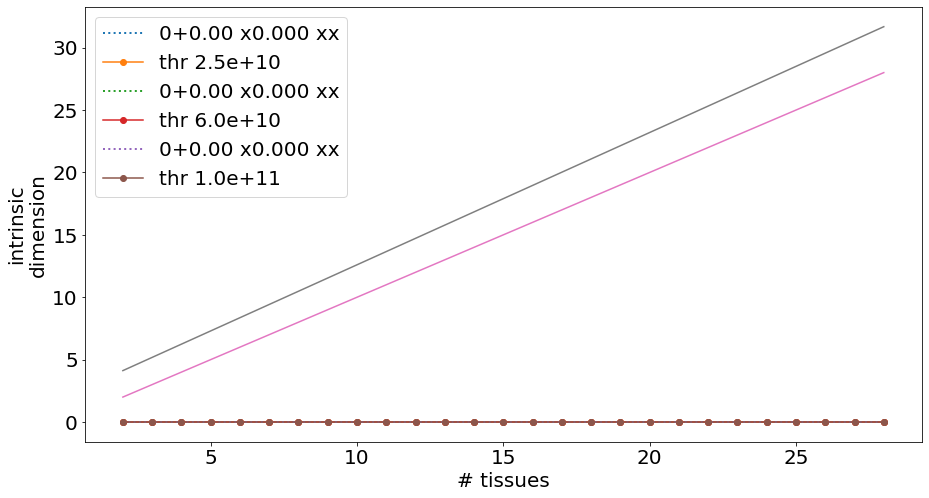

In [12]:
x=np.array([i for i in expl_var.keys()])
parab = lambda x,a,b,c: a+ b*x+c*x*x
fig=plt.figure(figsize=(15,8))
for thr in [2.5e10,6e10,1e11]:
    plot_data=[]
    for k in expl_var.keys():
        var=np.array(expl_var[k])
        plot_data.append(len(var[var>thr]))
    par, pot = curve_fit(parab, x,plot_data)
    plt.plot(x, parab(x, *par), ls=':', lw=2, label="%d+%.2f x%.3f xx"%(par[0],par[1],par[2]))
    plt.plot(x,plot_data, marker='o', label="thr %.1e"%thr)
plt.xlabel('# tissues', fontsize=20)
plt.ylabel('intrinsic\ndimension', fontsize=20)
plt.plot(x,x)
plt.plot(x,1.06*x+2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()
fig.savefig("intrinsic_dimension.pdf")

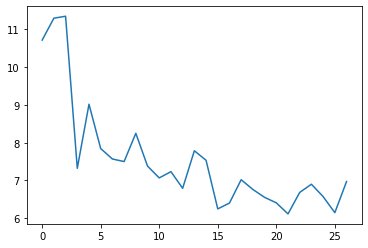

In [18]:
plt.plot([x for _,x in expl_var.items()])

In [ ]:
#pd.DataFrame(data=expl_var).to_csv("intrdim.csv",index=False, header=True)

In [13]:
df_ev=pd.read_csv("intrdim.csv",  header=0)
df_ev.columns=df_ev.columns.astype(int)
expl_var=df_ev.to_dict('list')

{2: [2067825745367.5718,
  369259744645.3673,
  249599695268.6041,
  98131526705.9654,
  76469316350.4223,
  52674832193.263,
  42418749529.73288,
  40590299980.61155,
  31100342338.64092,
  27106007852.33482,
  23041332922.36156,
  20134432062.85581,
  19080007919.546337,
  15105597969.30079,
  13056808858.170773,
  11199060930.396318,
  10631987539.91962,
  9272831002.041979,
  8064795539.416891,
  8048090924.705367,
  7181671807.564355,
  6651466863.640252,
  6161377752.486006,
  5972806708.434754,
  5482671955.117629,
  5144310016.063831,
  4866962350.702626,
  4454620742.428885,
  4134404207.1346726,
  3534365662.5661173,
  3325125767.136445,
  2882384185.8232594,
  2791498955.7612357,
  2604001516.5484905,
  2313012341.136245,
  2222973321.854763,
  2128387691.9855504,
  2056570504.1083386,
  1953290220.2995648,
  1786723089.7303236,
  1686621048.6370802,
  1608687264.9043958,
  1552015875.3622274,
  1456512334.3309324,
  1382470592.993641,
  1325261188.5094724,
  1276706340.7440